# Predicting Youth Riding with Drinking Drivers

### Table of contents

- [Intro](#1-bullet)
- [Loading Data and data cleaning](#2-bullet)
- [EDA](#3-bullet)
- [Feature engineering and prep data for modeling](#4-bullet)
- [Logistic Regression](#5-bullet)
- [Random Forest](#6-bullet)
- [XGBoost](#7-bullet)
- [Models Results](#8-bullet)
- [Conclusion](#9-bullet)

### Intro<a class="anchor" id="1-bullet"></a>

In this project, we aim to address the heightened risk of car accidents among youth in the U.S. Specifically, we focus on identifying factors that contribute to high schoolers riding with drinking drivers. By analyzing a 2007 dataset from the Youth Risk Behavior Surveillance System (YRBSS), an annual survey conducted by the Centers for Disease Control and Prevention (CDC) to monitor youth behaviors, we seek to gain insights that can help prevent other teens from engaging in similar risky behaviors.

### Loading Data and data cleaning<a class="anchor" id="2-bullet"></a>

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import resample

import xgboost as xgb
from sklearn.metrics import plot_confusion_matrix, f1_score, roc_curve, auc

In [2]:
# Load data

df = pd.read_csv("YouthRisk2007.csv")

In [3]:
# let's take an initial look at the data

df.head(10)

,Unnamed: 0,ride.alc.driver,female,grade,age4,smoke,DriverLicense
0,1,1,1.0,10.0,15.0,1.0,0.0
1,2,1,1.0,10.0,18.0,1.0,1.0
2,3,1,NaN,NaN,NaN,NaN,NaN
3,4,0,0.0,11.0,17.0,0.0,1.0
4,5,0,0.0,11.0,17.0,0.0,1.0
5,6,0,0.0,11.0,17.0,1.0,1.0
6,7,0,0.0,11.0,17.0,0.0,1.0
7,8,0,0.0,11.0,17.0,1.0,1.0
8,9,0,0.0,11.0,16.0,0.0,1.0
9,10,0,1.0,11.0,17.0,0.0,1.0


it appears the first column was imported as an index so we can go ahead and drop that

In [4]:
df = df.drop('Unnamed: 0', axis=1)

It also appears we have some null values. Now Let's check for data types and null values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13387 entries, 0 to 13386
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ride.alc.driver  13387 non-null  int64  
 1   female           12632 non-null  float64
 2   grade            13320 non-null  float64
 3   age4             13333 non-null  float64
 4   smoke            12999 non-null  float64
 5   DriverLicense    13333 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 627.6 KB


Data types seem to be fine, now let's count null values

In [6]:
df.isnull().sum()

ride.alc.driver      0
female             755
grade               67
age4                54
smoke              388
DriverLicense       54
dtype: int64

It seems we have some null values. Since we don't have that many we can get rid of those to clean the data

In [7]:
df.dropna(inplace=True)

Let's see if the changes were effective

In [8]:
df.isnull().sum()

ride.alc.driver    0
female             0
grade              0
age4               0
smoke              0
DriverLicense      0
dtype: int64

Let's also rename most of the columns so that they are more readable

In [9]:
df.rename(columns={'age4': 'Age'}, inplace=True)
df.rename(columns={'female': 'Gender'}, inplace=True)
df.rename(columns={'grade': 'Grade'}, inplace=True)
df.rename(columns={'smoke': 'Smoker'}, inplace=True)
df.rename(columns={'ride.alc.driver': 'DrunkDriver'}, inplace=True)

Let's take an initial look at the distribution

In [10]:
df.describe()

,DrunkDriver,Gender,Grade,Age,Smoker,DriverLicense
count,12282.000000,12282.000000,12282.000000,12282.000000,12282.000000,12282.000000
mean,0.313385,0.525973,10.523449,16.152337,0.535581,0.676193
std,0.463888,0.499345,1.114185,1.209777,0.498753,0.467946
min,0.000000,0.000000,9.000000,14.000000,0.000000,0.000000
25%,0.000000,0.000000,10.000000,15.000000,0.000000,0.000000
50%,0.000000,1.000000,11.000000,16.000000,1.000000,1.000000
75%,1.000000,1.000000,12.000000,17.000000,1.000000,1.000000
max,1.000000,1.000000,12.000000,18.000000,1.000000,1.000000


### EDA<a class="anchor" id="3-bullet"></a>

Let's check for the age distribution with a boxplot

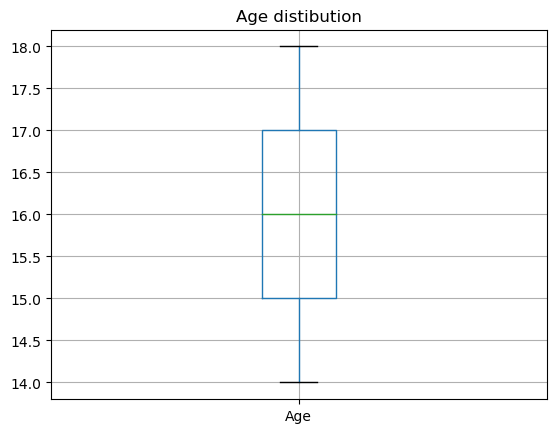

In [11]:
df.boxplot('Age')
plt.title('Age distibution')
plt.show()

The age distribution looks fairly simmetrical across all values, with a mean of about 16. Now let's check for the distribution of smokers in the data

In [12]:
df['Smoker'].value_counts()

1.0    6578
0.0    5704
Name: Smoker, dtype: int64

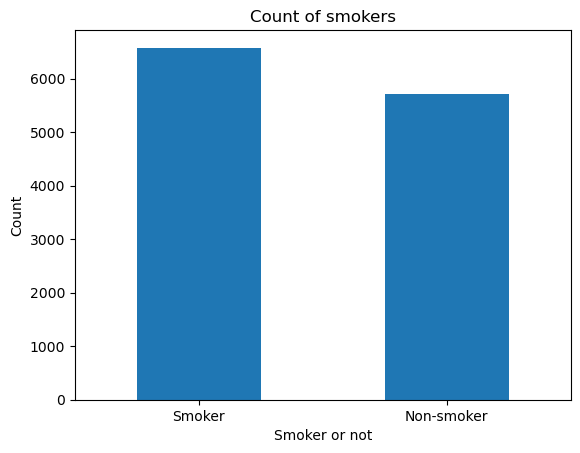

In [13]:
df['Smoker'].value_counts().plot(kind='bar')

plt.xlabel('Smoker or not')
plt.ylabel('Count')
plt.title('Count of smokers')
plt.xticks([0, 1], ['Smoker', 'Non-smoker'], rotation=0)

# Show the plot
plt.show()

Let's check for the distribution for grade

In [14]:
df['Grade'].value_counts()

11.0    3133
12.0    3129
10.0    3058
9.0     2962
Name: Grade, dtype: int64

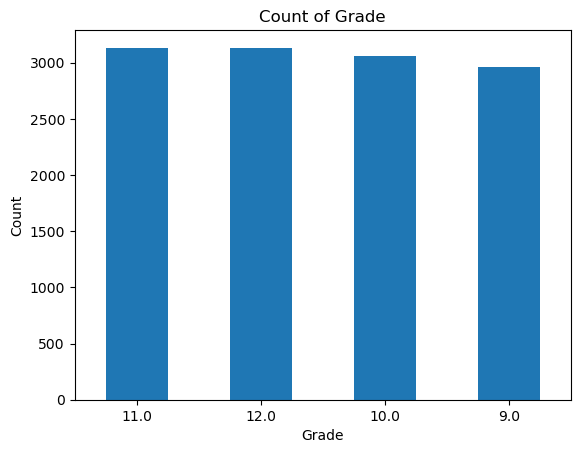

In [15]:
df['Grade'].value_counts().plot(kind='bar')

plt.xlabel('Grade')
plt.ylabel('Count')
plt.title('Count of Grade')
plt.xticks(rotation=0)

# Show the plot
plt.show()

So far our features seem to be pretty balanced, let's check for how many teens in the dataset have a driver's license

In [16]:
df['DriverLicense'].value_counts()

1.0    8305
0.0    3977
Name: DriverLicense, dtype: int64

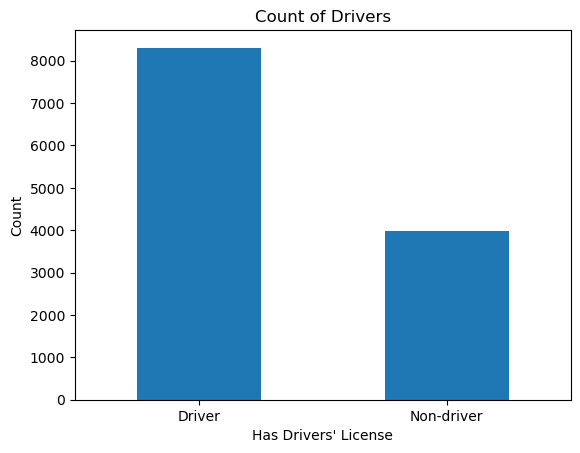

In [17]:
df['DriverLicense'].value_counts().plot(kind='bar')

plt.xlabel("Has Drivers' License")
plt.ylabel('Count')
plt.title('Count of Drivers')
plt.xticks([0, 1], ['Driver', 'Non-driver'], rotation=0)

# Show the plot
plt.show()

The data seem to be a little unbalanced towards teens with a driver's license, now let's check for gender in the dataset

In [18]:
df['Gender'].value_counts()

1.0    6460
0.0    5822
Name: Gender, dtype: int64

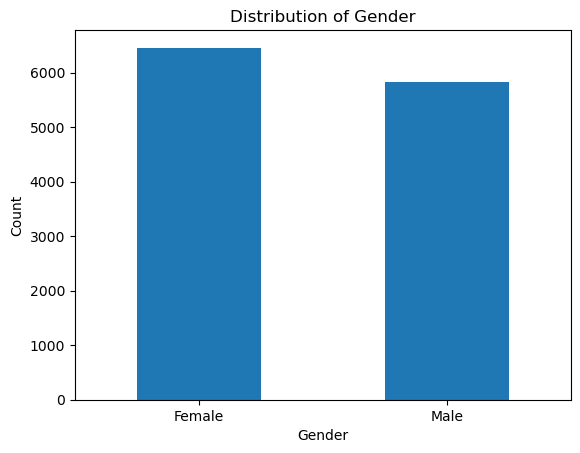

In [19]:
df['Gender'].value_counts().plot(kind='bar')

plt.xlabel("Gender")
plt.ylabel('Count')
plt.title('Distribution of Gender')
plt.xticks([0, 1], ['Female', 'Male'], rotation=0)

# Show the plot
plt.show()

Slightly more woman than man in the dataset. Now let's check the distribution of our target variable, whether or not the teen rode with a drunk driver in the last 30 days

In [20]:
df['DrunkDriver'].value_counts()

0    8433
1    3849
Name: DrunkDriver, dtype: int64

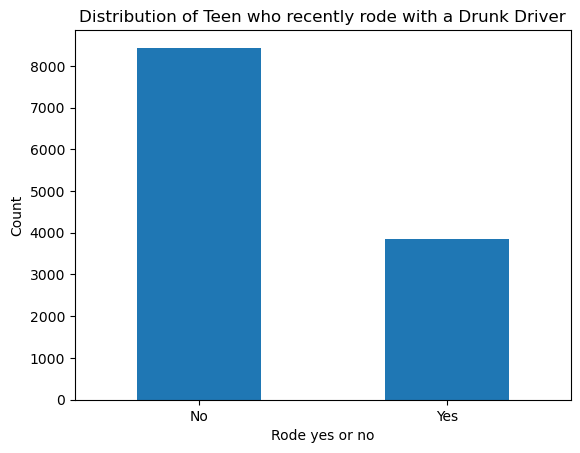

In [21]:
df['DrunkDriver'].value_counts().plot(kind='bar')

plt.xlabel('Rode yes or no')
plt.ylabel('Count')
plt.title('Distribution of Teen who recently rode with a Drunk Driver')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)

# Show the plot
plt.show()

The dataset seems to be biased towards teens that did not ride with a drunk driver in the past month, it could also be that there were issues collecting the data. It is a good idea to deal with the unbalance of this data later. Since this is our target variable, we can use upsampling techniques to balance this data.

We can now plot some stacked bar charts and see if any features seem more important

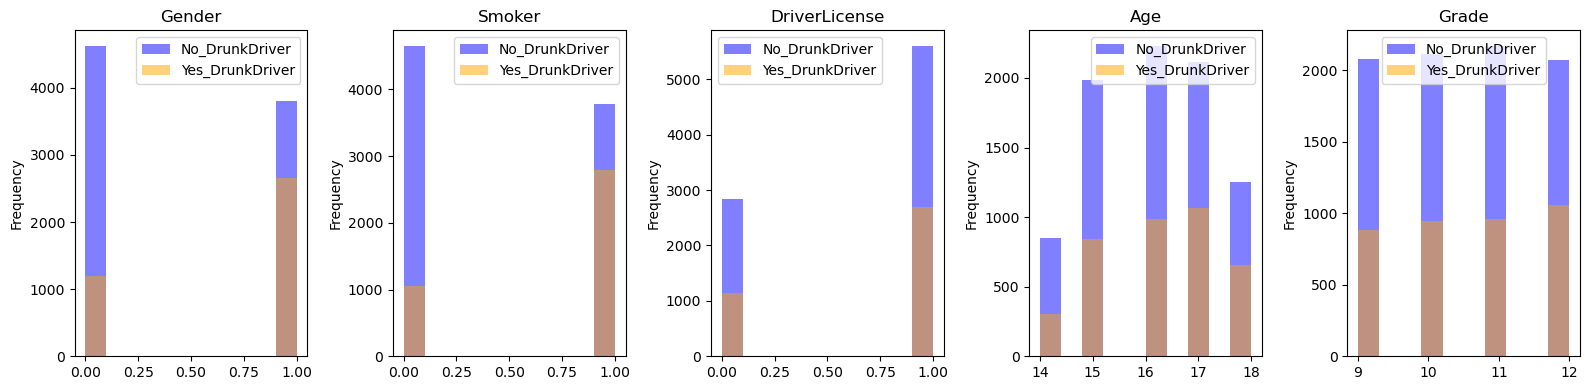

In [22]:
feature_columns = ['Gender', 'Smoker', 'DriverLicense', 'Age', 'Grade']

fig, axes = plt.subplots(nrows=1, ncols=len(feature_columns), figsize=(16, 4))

for i, feature in enumerate(feature_columns):
    target_0 = df[df['DrunkDriver'] == 0][feature]
    target_1 = df[df['DrunkDriver'] == 1][feature]
    
    axes[i].hist(target_0, bins=10, alpha=0.5, label='No_DrunkDriver', color='blue')
    axes[i].hist(target_1, bins=10, alpha=0.5, label='Yes_DrunkDriver', color='orange')
    
    axes[i].set_title(f'{feature}')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()

plt.tight_layout()
plt.show()

Right away the features that seem more outstanding are Gender and Smoker. It appears that the girls tend to ride more with drunk drivers and smokers also have a higher tendency to ride with drunk drivers.

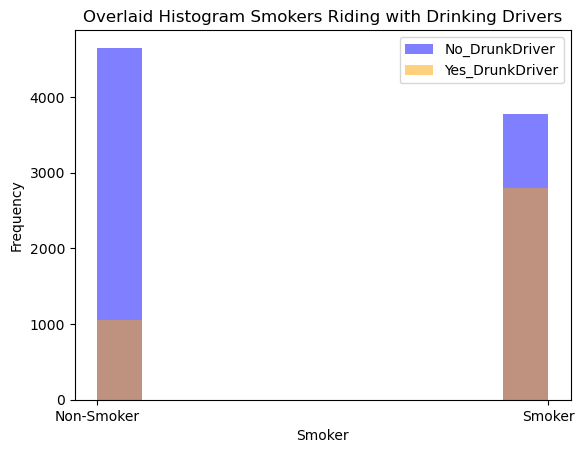

In [23]:
feature_target_0 = df[df['DrunkDriver'] == 0]['Smoker']
feature_target_1 = df[df['DrunkDriver'] == 1]['Smoker']


num_bins = 10


plt.hist(feature_target_0, bins=num_bins, alpha=0.5, label='No_DrunkDriver', color='blue')
plt.hist(feature_target_1, bins=num_bins, alpha=0.5, label='Yes_DrunkDriver', color='orange')


plt.xlabel('Smoker')
plt.ylabel('Frequency')
plt.title('Overlaid Histogram Smokers Riding with Drinking Drivers')


plt.xticks([0, 1], ['Non-Smoker', 'Smoker'])
plt.legend()


plt.show()

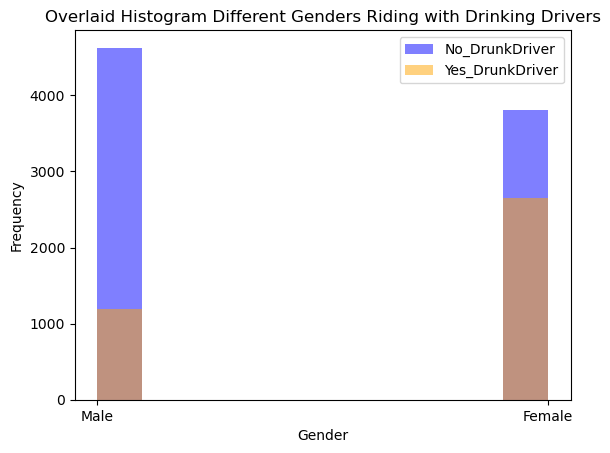

In [24]:
feature_target_0 = df[df['DrunkDriver'] == 0]['Gender']
feature_target_1 = df[df['DrunkDriver'] == 1]['Gender']


num_bins = 10


plt.hist(feature_target_0, bins=num_bins, alpha=0.5, label='No_DrunkDriver', color='blue')
plt.hist(feature_target_1, bins=num_bins, alpha=0.5, label='Yes_DrunkDriver', color='orange')


plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Overlaid Histogram Different Genders Riding with Drinking Drivers')



plt.xticks([0, 1], ['Male', 'Female'])
plt.legend()

plt.show()

### Feature engineering and prep data for modeling<a class="anchor" id="4-bullet"></a>

We can now create a new feature to analyze if teens that have potentially repeated a school year are more likely to ride with drunk drivers

In [22]:
def check_repeated(row):
    school_year = row['Grade']
    age = row['Age']
    
    if school_year == 9:
        expected_age = 15
    elif school_year == 10:
        expected_age = 16
    elif school_year == 11:
        expected_age = 17
    else:
        expected_age = 18

    if age > expected_age:
        return 1
    else:
        return 0

df['Has_repeated'] = df.apply(check_repeated, axis=1)

Let's check our dataset again to see the new feature

In [23]:
df.head()

,DrunkDriver,Gender,Grade,Age,Smoker,DriverLicense,Has_repeated
0,1,1.0,10.0,15.0,1.0,0.0,0
1,1,1.0,10.0,18.0,1.0,1.0,1
3,0,0.0,11.0,17.0,0.0,1.0,0
4,0,0.0,11.0,17.0,0.0,1.0,0
5,0,0.0,11.0,17.0,1.0,1.0,0


Let's plot a bar graph to see the distribution of our new feature

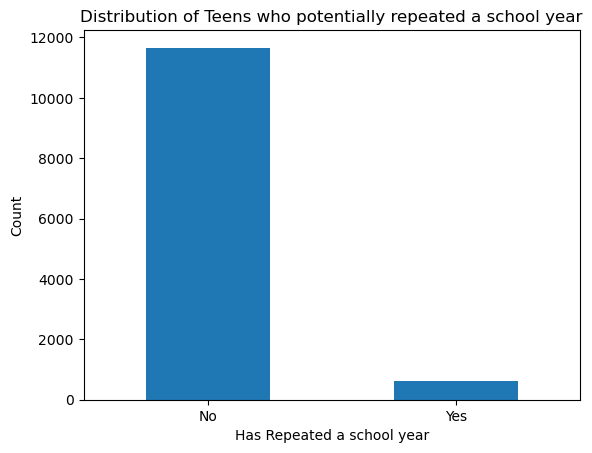

In [24]:
df['Has_repeated'].value_counts().plot(kind='bar')

plt.xlabel('Has Repeated a school year')
plt.ylabel('Count')
plt.title('Distribution of Teens who potentially repeated a school year')
plt.xticks([0, 1], ['No', 'Yes'], rotation=0)

plt.show()

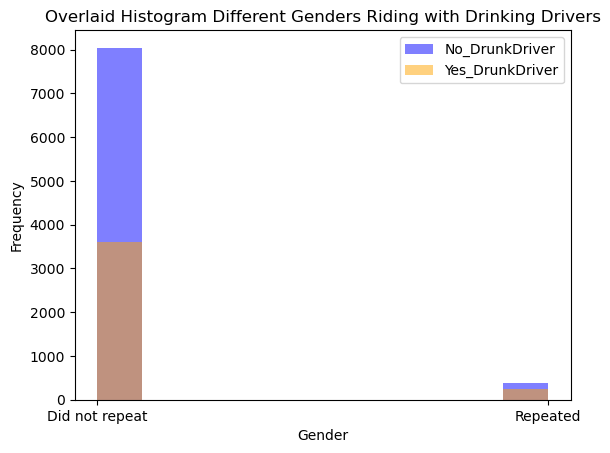

In [25]:
feature_target_0 = df[df['DrunkDriver'] == 0]['Has_repeated']
feature_target_1 = df[df['DrunkDriver'] == 1]['Has_repeated']


num_bins = 10


plt.hist(feature_target_0, bins=num_bins, alpha=0.5, label='No_DrunkDriver', color='blue')
plt.hist(feature_target_1, bins=num_bins, alpha=0.5, label='Yes_DrunkDriver', color='orange')


plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.title('Overlaid Histogram Different Genders Riding with Drinking Drivers')



plt.xticks([0, 1], ['Did not repeat', 'Repeated'])
plt.legend()

plt.show()

It appears very few kids potentially repeated a school year at some point. Our machine learning models may not rely on this feature since it only accounted for a very small percentage of our sample. 

Now we should upsample our data since we identified in our EDA that our target variable is unbalanced 

In [27]:
majority_class = df[df['DrunkDriver'] == 0]
minority_class = df[df['DrunkDriver'] == 1]


upsampled_minority = resample(minority_class,
                              replace=True,  
                              n_samples=len(majority_class),  
                              random_state=9)  
up_df = pd.concat([majority_class, upsampled_minority])

Let's check and see the new count of our data based on our target variable

In [28]:
print(up_df['DrunkDriver'].value_counts())

0    8433
1    8433
Name: DrunkDriver, dtype: int64


It seems our data is now balanced, now let's check the correlation coefficients and create a heatmap to better visualize that

In [29]:
up_df.corr()

,DrunkDriver,Gender,Grade,Age,Smoker,DriverLicense,Has_repeated
DrunkDriver,1.000000,0.239895,0.034212,0.055921,0.282928,0.041955,0.042191
Gender,0.239895,1.000000,0.245656,0.289905,0.374380,0.245422,0.082467
Grade,0.034212,0.245656,1.000000,0.865131,0.111623,0.740369,-0.148043
Age,0.055921,0.289905,0.865131,1.000000,0.151593,0.822462,0.157272
Smoker,0.282928,0.374380,0.111623,0.151593,1.000000,0.130477,0.072768
DriverLicense,0.041955,0.245422,0.740369,0.822462,0.130477,1.000000,0.164881
Has_repeated,0.042191,0.082467,-0.148043,0.157272,0.072768,0.164881,1.000000


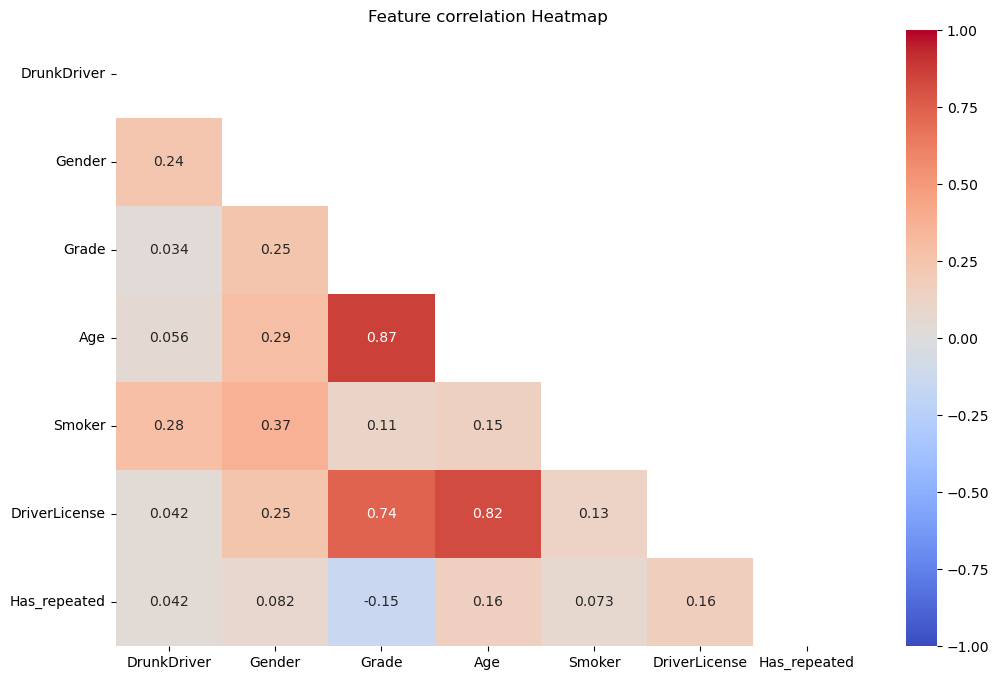

In [30]:
corr_matrix = up_df.corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))


plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, mask=mask)


plt.title('Feature correlation Heatmap')
plt.show()

We have very high correlation between 'Grade', 'Age' and 'DriverLicense'. This is expected, because depending on the grade, teens will tend to be a certain age and generally, the older the teen the more likely to own a driver's license.

We will drop two features to not have multicolinearity in our model. Looking back at our EDA 'Grade' seems to be more interesting to keep, so we will drop 'Age' and 'DriverLicense'

In [31]:
X=up_df[['Smoker', 'Gender','Grade', 'Has_repeated']]
y=up_df['DrunkDriver']

Now Let's check for our P values

In [32]:
X_withconstant = sm.add_constant(X)

In [33]:
# instantiate model

mylogreg = sm.Logit(y, X_withconstant)

# Display summary to look at results
mylogreg_results = mylogreg.fit()
mylogreg_results.summary()

Optimization terminated successfully.
         Current function value: 0.640776
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            DrunkDriver   No. Observations:                16866
Model:                          Logit   Df Residuals:                    16861
Method:                           MLE   Df Model:                            4
Date:                Fri, 02 Jun 2023   Pseudo R-squ.:                 0.07556
Time:                        10:57:12   Log-Likelihood:                -10807.
converged:                       True   LL-Null:                       -11691.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.3560      0.159     -2.241      0.025      -0.667      -0.045
Smoker           0.9605      0.035     27.493      0.000       0.892       1.029
Gender           0.7015      0.036     19.626      0.000       0.631       0.772
Grade           -0.0588      0.015     -3.844      0.000      -0.089      -0.029
Has_repeated     0.0781      0.073      1.073      0.283      -0.064       0.221
================================================================================
"""

The p value of our engineered feature ('Has_repeated') is higher than our threshold (0.05), let's drop that and try again

In [34]:
X=up_df[['Smoker', 'Gender', 'Grade']]
y=up_df['DrunkDriver']

In [35]:
X_withconstant = sm.add_constant(X)

In [36]:
mylogreg = sm.Logit(y, X_withconstant)

mylogreg_results = mylogreg.fit()
mylogreg_results.summary()

Optimization terminated successfully.
         Current function value: 0.640810
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            DrunkDriver   No. Observations:                16866
Model:                          Logit   Df Residuals:                    16862
Method:                           MLE   Df Model:                            3
Date:                Fri, 02 Jun 2023   Pseudo R-squ.:                 0.07551
Time:                        10:57:30   Log-Likelihood:                -10808.
converged:                       True   LL-Null:                       -11691.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3246      0.156     -2.079      0.038      -0.631      -0.019
Smoker         0.9623      0.035     27.579      0.000       0.894       1.031
Gender         0.7054      0.036     19.829      0.000       0.636       0.775
Grade         -0.0617      0.015     -4.095      0.000      -0.091      -0.032
==============================================================================
"""

It looks like we are ready to split our data into train and test sets

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=9)

Now let's scale our data

In [40]:
scaler = StandardScaler()
X_train_sca = scaler.fit_transform(X_train)

X_test_sca = scaler.transform(X_test)

### Logistic Regression<a class="anchor" id="5-bullet"></a>

Let's start with Logistic Regression using our scaled data

In [41]:
logreg = LogisticRegression()

logreg.fit(X_train_sca, y_train)

y_pred_log1 = logreg.predict(X_test_sca)


accuracy_lr = accuracy_score(y_test, y_pred_log1)
precision_lr = precision_score(y_test, y_pred_log1)
recall_lr = recall_score(y_test, y_pred_log1)
f1_lr = f1_score(y_test, y_pred_log1)

print("Accuracy:{:.2f}%".format(accuracy_lr*100))
print("Precision:{:.2f}%".format(precision_lr*100))
print("Recall:{:.2f}%".format(recall_lr*100))
print("F1 Score:{:.2f}%".format(f1_lr*100))

Accuracy:65.06%
Precision:65.20%
Recall:67.03%
F1 Score:66.10%


Let's print out coefficients to analyze how the variables impact our model

In [42]:
print("Coefficients:", logreg.coef_)
print("Intercept:", logreg.intercept_)

Coefficients: [[ 0.46420371  0.35119894 -0.06941558]]
Intercept: [-0.01363016]


Now Let's plot our coefficients

<Figure size 640x480 with 0 Axes>

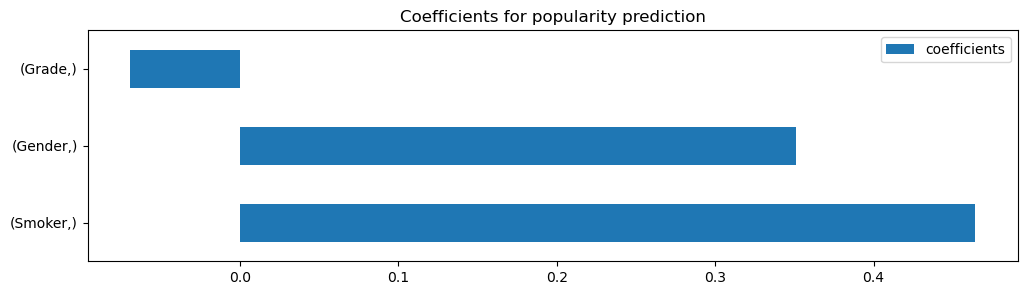

In [43]:
plt.figure()

pd.DataFrame(
    data={"coefficients": logreg.coef_.ravel()},
    index=[X.columns],
).plot(kind="barh", figsize=(12, 3), title="Coefficients for popularity prediction")

plt.show()

Let's also take a look at our odds ratio

In [44]:
coef = logreg.coef_[0]
names = X.columns

odds_ratios = np.exp(coef)


for name, odd in zip(names, odds_ratios):
    print(f"Odds ratio for {name}: {odd:.3f}")

Odds ratio for Smoker: 1.591
Odds ratio for Gender: 1.421
Odds ratio for Grade: 0.933


As expected, Gender and Smoker are the features the model is using the most to make the predictions. We can also plot the ROC curve to check the performance of our model

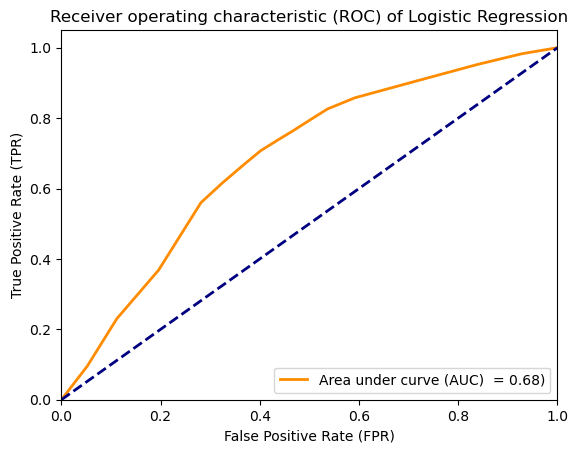

In [46]:
# Make soft prediction for the ROC plot 
y_pred_sft_log = logreg.predict_proba(X_test_sca)[:,1]


fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_sft_log)
roc_auc_lr = auc(fpr_lr, tpr_lr)


plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='Area under curve (AUC)  = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver operating characteristic (ROC) of Logistic Regression')
plt.legend(loc="lower right")
plt.show()

Our model is not performing too well, we should address the limitations and other considerations in the conclusion

### Random Forest<a class="anchor" id="6-bullet"></a>

Since this model does not require scaled data we will use our X_test set

In [49]:
rf = RandomForestClassifier(n_estimators=100, random_state=29)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=29)

In [50]:
# Make hard prediction
y_pred_rf = rf.predict(X_test)

# Make soft prediction, we will use that later to create the ROC curve plot
y_pred_sft_rf = rf.predict_proba(X_test)[:,1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("Accuracy:{:.2f}%".format(accuracy_rf*100))
print("Precision:{:.2f}%".format(precision_rf*100))
print("Recall:{:.2f}%".format(recall_rf*100))
print("F1 Score:{:.2f}%".format(f1_rf*100))

Accuracy:64.90%
Precision:64.36%
Recall:69.36%
F1 Score:66.77%


We can also plot out the ROC curve to further analyze the performance of this model

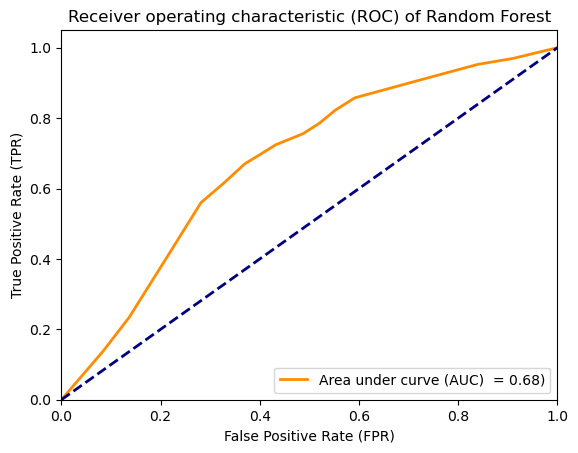

In [52]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_sft_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='Area under curve (AUC)  = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver operating characteristic (ROC) of Random Forest')
plt.legend(loc="lower right")
plt.show()

### XGBoost<a class="anchor" id="7-bullet"></a>

Since XGBoost is also a Tree-based algorithm, we don't need to use our scaled data. So again we will use our unscaled train set (X_train)

In [53]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

params = {
    'objective': 'binary:logistic',  
    'eval_metric': 'logloss'  
}


num_rounds = 100  
xgb_model = xgb.train(params, dtrain, num_rounds)


y_pred_proba = xgb_model.predict(dtest)


auc_score = roc_auc_score(y_test, y_pred_proba)

y_pred_binary = [round(pred) for pred in y_pred_proba] 


accuracy_xgb = accuracy_score(y_test, y_pred_binary)
precision_xgb = precision_score(y_test, y_pred_binary)
recall_xgb = recall_score(y_test, y_pred_binary)
f1_xgb = f1_score(y_test, y_pred_binary)



print("Accuracy: {:.2f}%".format(accuracy_xgb * 100))
print("Precision: {:.2f}%".format(precision_xgb * 100))
print("Recall: {:.2f}%".format(recall_xgb * 100))
print("F1 Score: {:.2f}%".format(f1_xgb * 100))

Accuracy: 64.90%
Precision: 64.36%
Recall: 69.36%
F1 Score: 66.77%


We can once more plot the ROC curve to evaluate the performance of this model

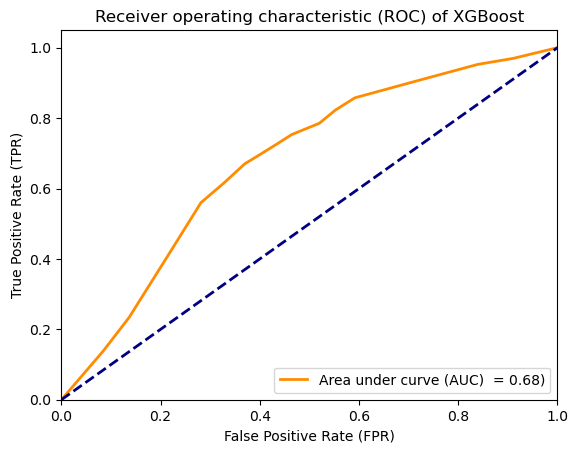

In [54]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba)

roc_auc_xgb = auc(fpr_xgb, tpr_xgb)


plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='Area under curve (AUC)  = %0.2f)' % roc_auc_lr)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver operating characteristic (ROC) of XGBoost')
plt.legend(loc="lower right")
plt.show()

Once again our model did not perform in the best way possible. Actually the performance of our XGBoost was exactly the same as our Random Forest, once more we will address the limitations and issues in the conclusion.

### Model Results<a class="anchor" id="8-bullet"></a>

Now we can compare the perfomance metrics of our 3 models and plot the different ROC curves together

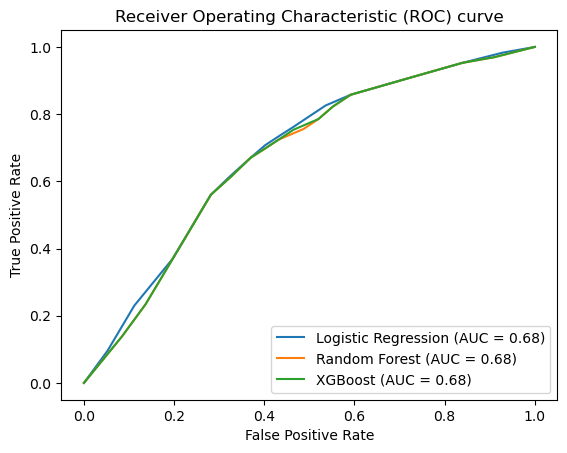

In [56]:
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')

# Add legend, title and axis labels
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

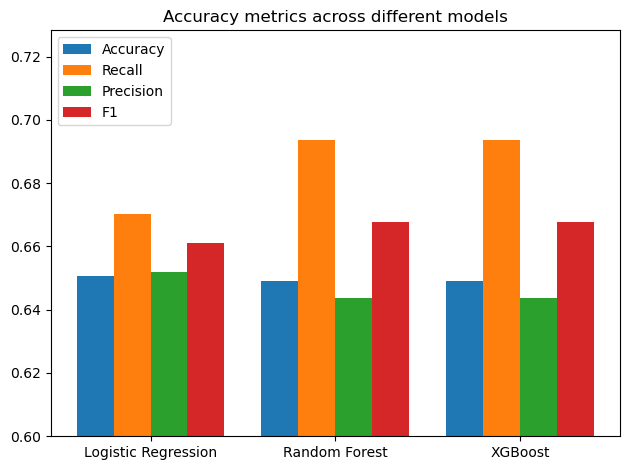

In [60]:
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracy = [accuracy_lr, accuracy_rf, accuracy_xgb] 
recall = [recall_lr, recall_rf, recall_xgb]
precision = [precision_lr, precision_rf, precision_xgb]
f1 = [f1_lr, f1_rf, f1_xgb]
    

x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots()
rects1 = ax.bar(x - 1.5*width, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, recall, width, label='Recall')
rects3 = ax.bar(x + 0.5*width, precision, width, label='Precision')
rects4 = ax.bar(x + 1.5*width, f1, width, label='F1')

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc='upper left')
ax.set_ylim(bottom=0.60)
plt.title('Accuracy metrics across different models')

fig.tight_layout()
plt.show()

### Conclusion<a class="anchor" id="9-bullet"></a>

Unfortunately, this dataset was not ideal for creating machine learning models. Due to the limited number of features and insufficient data, our progress with this project was restricted.

However, despite these challenges, we were able to draw some meaningful conclusions:

1. Girls tend to ride with drinking drivers more frequently than guys. This observation raises the possibility that guys themselves may be more inclined to drive while drinking, but exploring this topic would require further investigation.

2. Smokers also exhibit a higher tendency to ride with drinking drivers. This finding suggests a potential correlation between smoking habits and risky behavior in terms of alcohol consumption and transportation choices.

3. Differences in age or grade did not appear to have an impact on the likelihood of high schoolers riding with drinking drivers. Other factors may play a more significant role in influencing this behavior among teenagers.

4. Owning a driver's license did not seem to influence whether or not teens would ride with drinking drivers. This suggests that the possession of a license does not act as a deterrent or mitigate the risk associated with riding with an impaired driver.

To enhance future projects, the Centers for Disease Control and Prevention (CDC) could consider expanding the questionnaire to include additional relevant questions, such as:

- Whether the teen has ever repeated a grade and, if so, which one.
- Whether the teen has younger or older siblings.
- Whether the teen's parents are divorced.
- Whether the teen engages in drug use.
- Whether the teen feels subjected to peer pressure, among others.

Collecting more comprehensive data would be crucial for conducting effective machine learning projects. After upsampling, our dataset was only able to reach 16,866 rows.

In conclusion, although the dataset had its limitations, we were able to work with it and derive some potentially valuable insights.